In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Enrique_Bolanos/Enrique_Bolanos_0004.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Enrique_Bolanos/Enrique_Bolanos_0005.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Enrique_Bolanos/Enrique_Bolanos_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Kathryn_Bigelow/Kathryn_Bigelow_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Kathryn_Bigelow/Kathryn_Bigelow_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/William_Macy/William_Macy_0003.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/William_Macy/William_Macy_0005.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/William_Macy/William_Macy_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/William_Macy/William_Macy_0004.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Will

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

# Update this line to the LFW dataset on Kaggle
lfw_dataset_path = kagglehub.dataset_download('jessicali9530/lfw-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# Define paths
data_dir = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'  # Adjust based on your Colab path

# Remove the extra 'lfw-deepfunneled' from the path
Faces = os.listdir(data_dir)
num_classes = len(Faces)

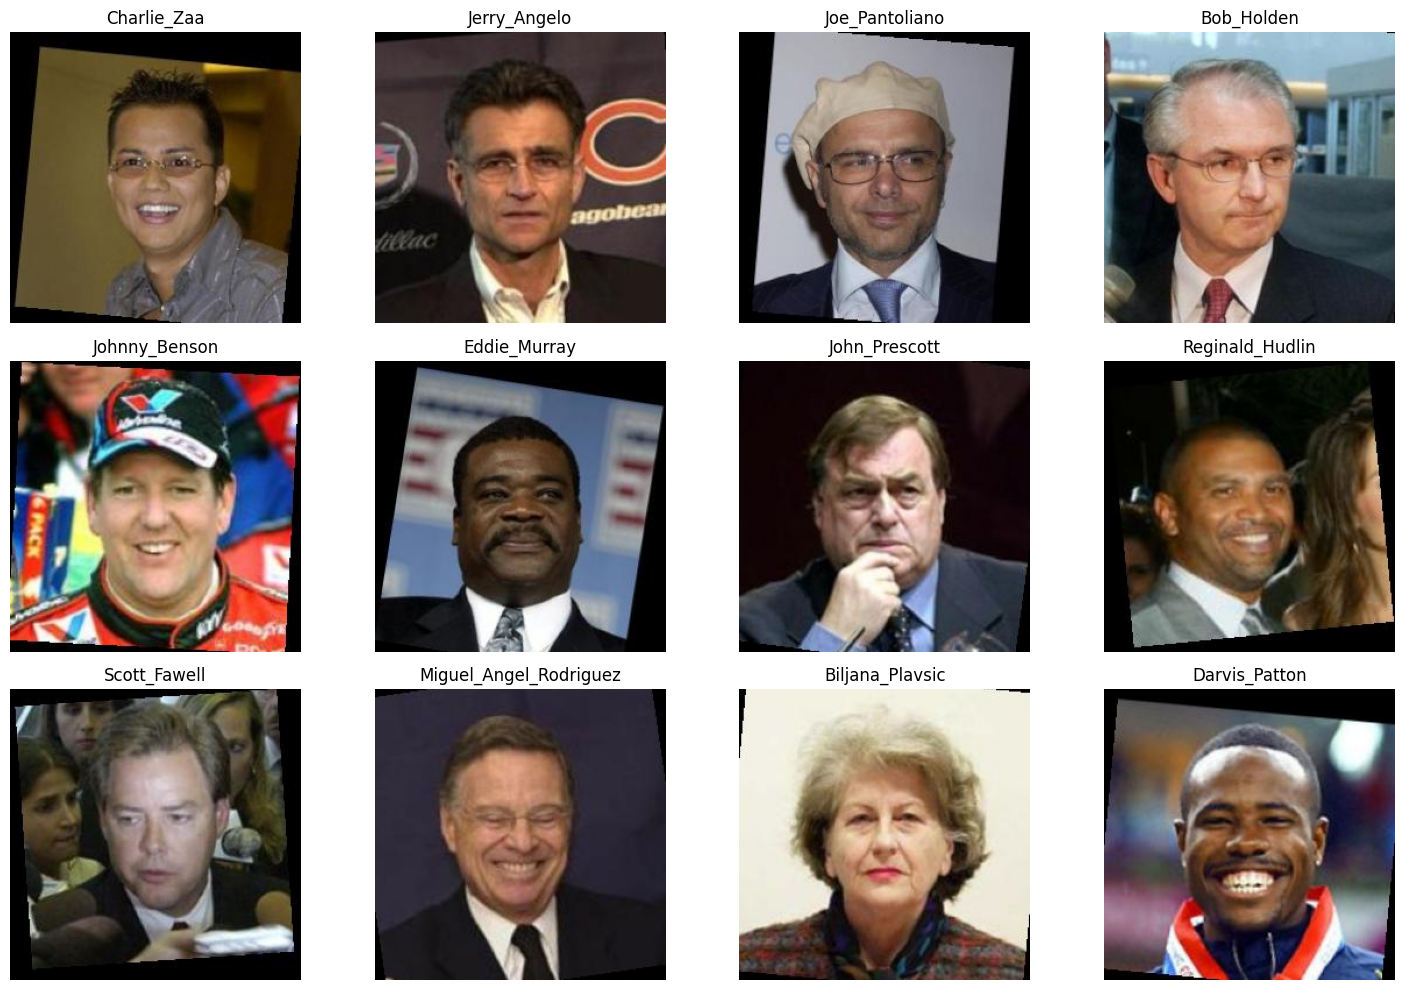

In [ ]:
# Visualize sample images
plt.figure(figsize=(15, 10))
for i in range(12):

    # Select a random face directory
    random_face_dir = np.random.choice(Faces)

    # Choose an image file from within the face directory
    img_file = np.random.choice(os.listdir(os.path.join(data_dir, random_face_dir)))

    # Construct the full image path
    img_path = os.path.join(data_dir, random_face_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(random_face_dir)
    plt.axis('off')
plt.tight_layout()
plt.show()

Total identities: 5749
Max images for one identity: 530
Identities with only 1 image: 4069


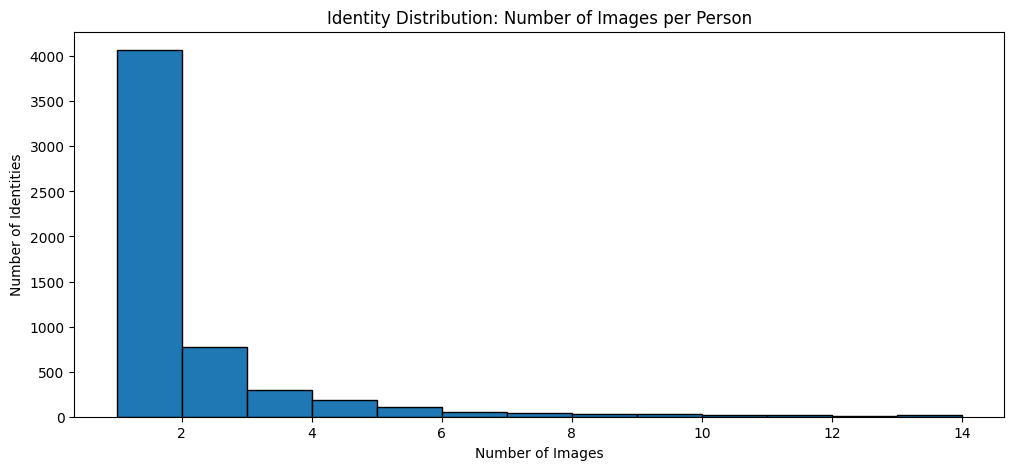

In [ ]:
# Count images per identity (folder)
from collections import Counter

identity_distribution = {}
for person in Faces:
    img_files = os.listdir(os.path.join(data_dir, person))
    identity_distribution[person] = len(img_files)

# Convert to DataFrame for visualization
id_df = pd.DataFrame(list(identity_distribution.items()), columns=["Identity", "Image_Count"])
id_df = id_df.sort_values(by="Image_Count", ascending=False)

# Summary
print("Total identities:", len(id_df))
print("Max images for one identity:", id_df['Image_Count'].max())
print("Identities with only 1 image:", (id_df['Image_Count'] == 1).sum())

# Plot
plt.figure(figsize=(12, 5))
plt.hist(id_df["Image_Count"], bins=range(1, 15), edgecolor='black')
plt.title("Identity Distribution: Number of Images per Person")
plt.xlabel("Number of Images")
plt.ylabel("Number of Identities")
plt.show()

       Width  Height  Brightness   Blurriness
count   99.0    99.0   99.000000    99.000000
mean   250.0   250.0   95.563799   390.084460
std      0.0     0.0   27.501927   267.457272
min    250.0   250.0   47.170229    42.331861
25%    250.0   250.0   74.989347   176.180460
50%    250.0   250.0   93.829387   350.224523
75%    250.0   250.0  113.630603   556.946942
max    250.0   250.0  183.504197  1172.841710


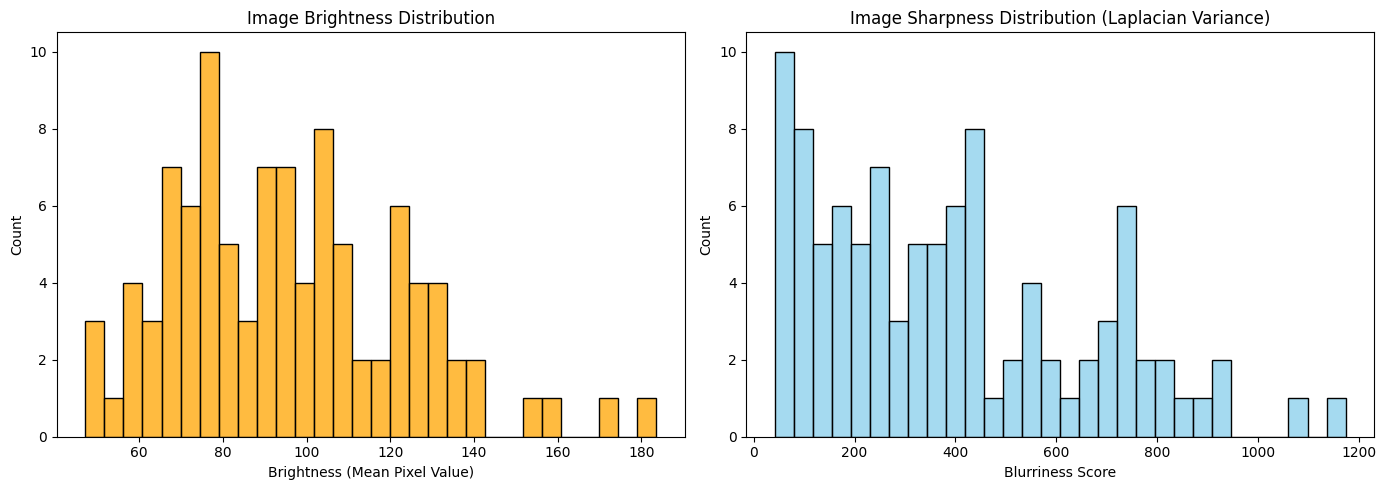

In [ ]:
from PIL import Image
import seaborn as sns

# Sample 1000 images to speed up analysis
sample_imgs = []
for person in np.random.choice(Faces, size=50, replace=False):
    imgs = os.listdir(os.path.join(data_dir, person))
    for img_name in imgs:
        img_path = os.path.join(data_dir, person, img_name)
        sample_imgs.append(img_path)
    if len(sample_imgs) >= 1000:
        break

resolutions = []
brightness = []
blurriness = []

def estimate_blur(img_arr):
    from cv2 import Laplacian, CV_64F
    import cv2
    gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()  # Variance of Laplacian

for img_path in sample_imgs:
    img = Image.open(img_path).convert("RGB")
    arr = np.array(img)
    h, w = arr.shape[:2]
    brightness.append(np.mean(arr))
    resolutions.append((w, h))
    blurriness.append(estimate_blur(arr))

# Convert to DataFrame
img_df = pd.DataFrame({
    "Width": [w for w, h in resolutions],
    "Height": [h for w, h in resolutions],
    "Brightness": brightness,
    "Blurriness": blurriness
})

print(img_df.describe())

# Plot brightness and blurriness
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(img_df["Brightness"], bins=30, color='orange', edgecolor='black')
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness (Mean Pixel Value)")

plt.subplot(1, 2, 2)
sns.histplot(img_df["Blurriness"], bins=30, color='skyblue', edgecolor='black')
plt.title("Image Sharpness Distribution (Laplacian Variance)")
plt.xlabel("Blurriness Score")

plt.tight_layout()
plt.show()


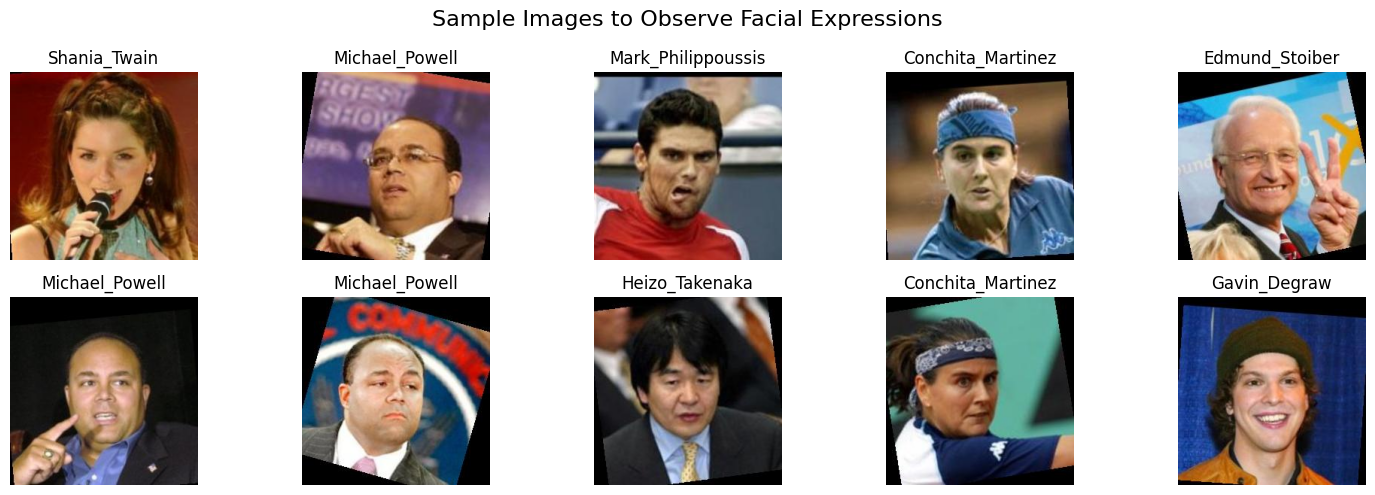

In [ ]:
# Show a few faces with potentially different expressions
plt.figure(figsize=(15, 5))
sample_paths = np.random.choice(sample_imgs, 10)
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(path)))
    plt.axis("off")
plt.suptitle("Sample Images to Observe Facial Expressions", fontsize=16)
plt.tight_layout()
plt.show()


Percentage of blurry images in sample: 15.15%


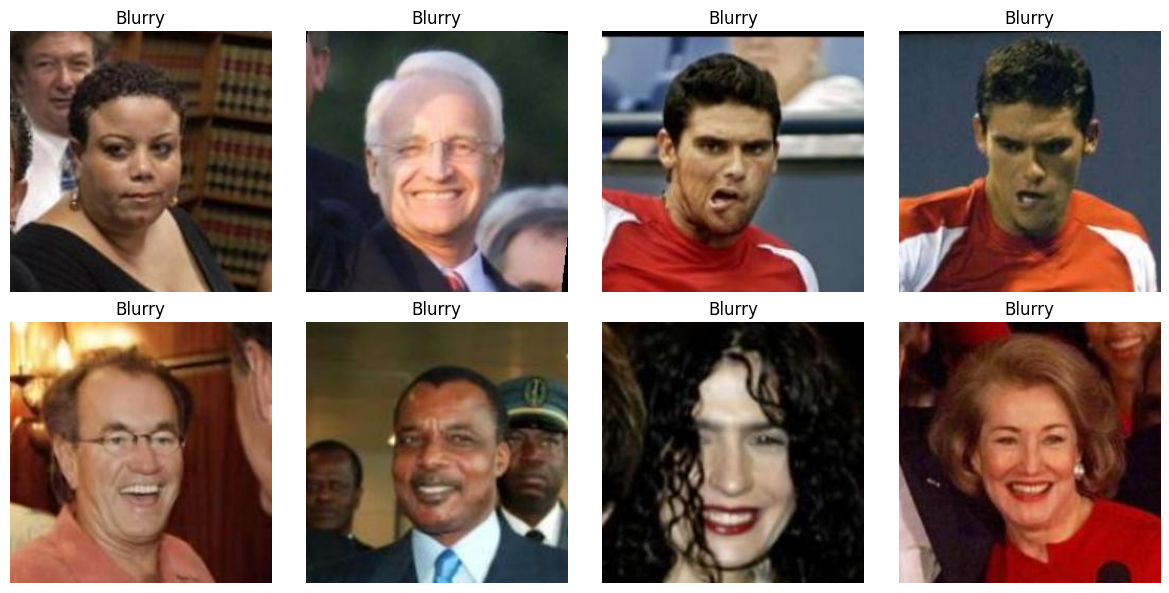

In [ ]:
# Flag blurry images (empirical threshold: <100 is considered blurry)
img_df["Is_Blurry"] = img_df["Blurriness"] < 100
blurry_ratio = img_df["Is_Blurry"].mean()
print(f"Percentage of blurry images in sample: {blurry_ratio*100:.2f}%")

# Show some blurry images
blurry_paths = [sample_imgs[i] for i in range(len(sample_imgs)) if img_df["Is_Blurry"].iloc[i]]
plt.figure(figsize=(12, 6))
for i, path in enumerate(blurry_paths[:8]):
    img = Image.open(path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title("Blurry")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (224, 224)
MAX_PEOPLE = 100         # Safe upper limit to avoid RAM crashes
MAX_IMAGES_PER_PERSON = 3

# Haar Cascade for Face Detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Face detection and cropping
def detect_and_crop_face(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped = img_array[y:y+h, x:x+w]
        resized = cv2.resize(cropped, IMG_SIZE)
        return resized / 255.0
    else:
        # No face found — fallback
        return cv2.resize(img_array, IMG_SIZE) / 255.0


In [ ]:
def preprocess_lfw_dataset_safe(data_dir, max_people=MAX_PEOPLE, max_images_per_person=MAX_IMAGES_PER_PERSON):
    images = []
    labels = []

    people = sorted(os.listdir(data_dir))[:max_people]
    for person in people:
        person_path = os.path.join(data_dir, person)
        image_files = os.listdir(person_path)[:max_images_per_person]

        for file in image_files:
            img_path = os.path.join(person_path, file)
            img = tf.keras.preprocessing.image.load_img(img_path)
            img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)

            processed_img = detect_and_crop_face(img_array)
            images.append(processed_img)
            labels.append(person)

    return np.array(images), np.array(labels)

# Run preprocessing
X, y = preprocess_lfw_dataset_safe('/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled')
print("Data shape:", X.shape, "Labels:", len(y))


Data shape: (153, 224, 224, 3) Labels: 153


In [ ]:
augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

img = X[31]  # One image from the dataset
img = np.expand_dims(img, axis=0)  # Required shape (1, 224, 224, 3)

# Example usage:
# train_aug.flow(X, y, batch_size=32)


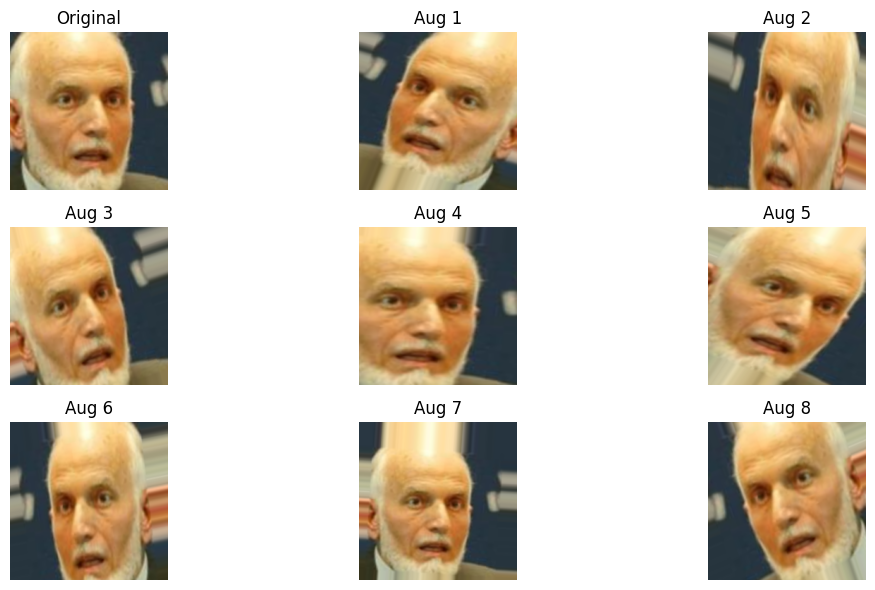

In [ ]:
# Generate a few augmented images
augmented_images = [next(augmentor.flow(img, batch_size=1))[0] for _ in range(8)]

# Plot original and augmented
plt.figure(figsize=(12, 6))
plt.subplot(3, 3, 1)
plt.imshow(X[31])
plt.title("Original")
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(3, 3, i + 2)
    plt.imshow(aug_img)
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()